In [47]:
import pandas as pd
import numpy as np
from os import listdir
from sklearn import datasets
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

# Preproceso del set de entrenamiento

# Funciones del uso de informacion del campo de descripcion

In [256]:
def isFloat(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

In [316]:
false = 0
true = 1
# ------------------------------------------------------------------------------
# INICIALIZAR DICCIONARIO
# ------------------------------------------------------------------------------
# pre: Recibe una lista de claves
# pos: devuelve un diccionario de esas claves recibidas inicializadas en cero

def inicializar_diccionario(keys):
    dicc = {}
    for charac in keys:
        dicc[charac] = 0
    return dicc

#------------------------------------------------------
# GET SURFACE
#------------------------------------------------------
def getSurface(df):
    dfSize = len(df.index)
    surfaces = df['surface_total_in_m2'].tolist()
    if 'description' not in df:
        return surfaces
    descriptions = df['description'].tolist()
    for i in range(0, dfSize):
        surfaceCalculated = 0
        words = descriptions[i].split()
        wordsSize = len(words)
        for pos in range(0, wordsSize):
            surfaceCalculated, offset, iFound = findSurface(words, pos, surfaceCalculated)
            if iFound:
                pos += offset
        surfaces[i] = validateSurface(surfaces[i], surfaceCalculated)
    return surfaces

# ------------------------------------------------------------------------------
# VALIDATE SURFACE
# ------------------------------------------------------------------------------
def validateSurface(surface, surfaceCalculated):
    if np.isnan(surface):
        return surfaceCalculated
    if surface != surfaceCalculated:
        return surface
    if surface == surfaceCalculated:
        return surface
    
# ------------------------------------------------------------------------------
# ENCONTRAR SUPERFICIE
# ------------------------------------------------------------------------------
def findSurface(words, i, surface):
    size = len(words)
    offset = 0 
    iFound = False
    if isFloat(words[i]):
        if (i + 2 < size) and words[i+1].lower() == "x" and isFloat(words[i+2]):
            a = float(words[i])
            b = float(words[i+2])        
            surface += a*b
            return surface, offset, iFound
    return surface, offset, iFound

# ------------------------------------------------------------------------------
# ENCONTRAR CANTIDAD DE AMBIENTES
# ------------------------------------------------------------------------------
def FindsNumberOfRooms(words, i, numberOfRooms):
    rooms = [
        "living", 
        "comedor", 
        "cocina", 
        "lavadero", 
        "dormitorio", 
        "vestidor",
        "baño"
    ]
    end = False
    size = len(words)
    if words[i].isdigit():
        if (i + 1 < size) and words[i+1].lower() == "ambientes":
            numberOfRooms = int(words[i])
            return numberOfRooms, end
        if (i + 1 < size) and words[i+1].lower() == "dormitorios":
            numberOfRooms += int(words[i])
            return numberOfRooms, not end
    if words[i].lower in rooms:
        numberOfRooms += 1
        return numberOfRooms, not end
    return numberOfRooms, not end

#------------------------------------------------------
# VALIDATE ROOM
#------------------------------------------------------
def validateRoom(numberOfRooms, numberOfRoomsCalculated):
    if np.isnan(numberOfRooms):
        return numberOfRoomsCalculated
    if numberOfRooms != numberOfRoomsCalculated:
        return numberOfRooms
    if numberOfRooms == numberOfRoomsCalculated:
        return numberOfRooms
    
#------------------------------------------------------
# GET ROOMS
#------------------------------------------------------
def getRooms(df):
    rooms = df['rooms'].tolist()
    if 'description' not in df:
        return rooms
    dfSize = len(df.index)
    descriptions = df['description'].tolist()
    for i in range(0, dfSize):
        numberOfRooms = 0
        words = descriptions[i].split()
        wordsSize = len(words)
        for pos in range(0, wordsSize):
            numberOfRooms, end = FindsNumberOfRooms(words, pos, numberOfRooms)
            if end:
                break
        rooms[i] = validateRoom(rooms[i], numberOfRooms)
    return rooms
# ------------------------------------------------------------------------------
# ENCONTRAR FRASE
# ------------------------------------------------------------------------------
# pre: Recibe un vector de palabras, la posicion en ese vector que se
# esta leyendo, y un vector de frases
# pos: Devuelve una tripla que dice si alguna de las frases en el
# vector "phrases", el offset el cual debe desplazarse la posicion de lectura
# del vector "words" y el indice en donde se encuantrala frase encontrada en el
# vector "phrases"

def encontrar_frase(words, i, phrases):
    offset = 0
    index = 0
    for phrase in phrases:
        if words[i].lower() in phrase:
            phrase_split = phrase.split()
            size = len(phrase_split)
            offset = size
            index = phrases.index(phrase)
            for j in range(0, size):
                if (i + j < size) and (words[i + j] != phrase_split[j]):
                    return False, offset, index
            return True, offset, index
    return False, offset, index


# ------------------------------------------------------------------------------
# CREAR DICCIONARIO DESCRIPCION
# ------------------------------------------------------------------------------
# pre: Recibe un dataframe
# pos: Devuelve una lista de diccionarios

def crear_diccionario_descripcion(df):
    characteristics = [
        "living",
        "cochera",
        "comedor",
        "pileta",
        "piscina"
    ]
    phrases = [
        "cancha de tenis",
        "club house",
        "sector de juegos infantiles",
        "futbol 5",
        "seguridad las 24 hs"
    ]
    size = len(df.index)
    dicc_list = []
    for i in range(0, size):
        dicc = inicializar_diccionario(characteristics + phrases)
        if 'description' not in df:
            dicc_list.append(dicc)
            continue
        description = list(df['description'])
        if type(description[i]) != type(""):
            dicc_list.append(dicc)
            continue
        words = description[i].split()
        lenght = len(words)
        for j in range(0, lenght):
            (wordBelongs, offset, index) = encontrar_frase(words, j, phrases)
            if wordBelongs:
                j += offset
                if j >= lenght:
                    break
                dicc[phrases[index]] = true
            if words[j].lower() in characteristics:
                dicc[words[j].lower()] = true
        dicc_list.append(dicc)
    return dicc_list

# ------------------------------------------------------------------------------
#
# ------------------------------------------------------------------------------

# Funciones de filtrado del data set

In [206]:
#----------------------------------------------------------------------
# Filtro de propiedades con precio calculable. Devuelve 1 si es válido. 
# De lo contrario, nan (Not A Number)
#----------------------------------------------------------------------
def filterPercentage(array):
    priceUSD, usdM2, surfaceTotal = array
    if priceUSD <= 0:
        return np.nan
    price = usdM2 * surfaceTotal
    dif = abs(price - priceUSD)
    if ((dif / priceUSD) * 100) <= 10:
        return 1
    return np.nan
#----------------------------------------------------------------------
# Filtro de propiedades con precio calculable. Devuelve 1 si es válido. 
# De lo contrario, nan (Not A Number)
#----------------------------------------------------------------------
def filterImposibles(array):
    priceUSD, usdM2, surfaceTotal = array
    if (np.isnan(surfaceTotal) or surfaceTotal <= 0) and not np.isnan(priceUSD) and not np.isnan(usdM2):
        return 1
    if np.isnan(priceUSD) and (not np.isnan(surfaceTotal) or surfaceTotal > 0) and not np.isnan(usdM2):
        return 1
    if np.isnan(usdM2) and (not np.isnan(surfaceTotal) or surfaceTotal > 0) and not np.isnan(priceUSD):
        return 1
    if not np.isnan(usdM2) and (not np.isnan(surfaceTotal) or surfaceTotal > 0) and not np.isnan(priceUSD):
        return 1
    return np.nan
#----------------------------------------------------------------------
# Cálculo del precio aproximado de venta
#----------------------------------------------------------------------
def fillPrice(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(priceUSD) and not np.isnan(usdM2):
        return (usdM2 * surfaceTotal)
    return priceUSD
#----------------------------------------------------------------------
# Cálculo del precio del metro cuadrado
#----------------------------------------------------------------------
def fillM2(array):
    priceUSD, usdM2, surfaceTotal = array
    if surfaceTotal <= 0:
        return np.nan
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return (priceUSD / surfaceTotal)
    return usdM2
#----------------------------------------------------------------------
# Cálculo de la superficie
#----------------------------------------------------------------------
def fillSurface(array):
    priceUSD, usdM2, surfaceTotal = array
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return (priceUSD / usdM2)
    return surfaceTotal
#----------------------------------------------------------------------
# Obtenemos el año y mes del nombre de archivo
#----------------------------------------------------------------------
def addDate(date, df):
    date_splitted = archive.split('-')
    month = date_splitted[3]
    year = date_splitted[2]
    date = year + '-' + month
    size = len(df.index)
    dates = pd.Series([date for i in range(0, size)])
    # y lo ponemos como dato en una columna
    df['date'] = dates
    df.loc[:, ['date']] = pd.to_datetime(df['date'], errors = 'coerce')
    return df
#----------------------------------------------------------------------
# Durante la carga de datos, se eliminan ciertas columnas que nos 
#resultan irrelevantes para el trabajo
#----------------------------------------------------------------------
def filterUnnecesaryColumns(df, isId):
    if 'surface_covered_in_m2' in df:
        df.drop('surface_covered_in_m2', axis = 1, inplace = True)
    if 'country_name' in df:
        df.drop('country_name', axis = 1, inplace = True)
    if 'price_aprox_local_currency' in df:
        df.drop('price_aprox_local_currency', axis = 1, inplace = True)
    if 'expenses' in df:
        df.drop('expenses', axis = 1, inplace = True)
    if 'properati_url' in df:
        df.drop('properati_url', axis = 1, inplace = True)
    if 'extra' in df:
        df.drop('extra', axis = 1, inplace = True)
    if 'geonames_id' in df:
        df.drop('geonames_id', axis = 1, inplace = True)
    if 'image_thumbnail' in df:
        df.drop('image_thumbnail', axis = 1, inplace = True)
    if 'operation' in df:
        df.drop('operation', axis = 1, inplace = True)
    if 'created_on' in df:
        df.drop('created_on', axis = 1, inplace = True)
    if 'lat-lon' in df:
        df.drop('lat-lon', axis = 1, inplace = True)
    if 'currency' in df:
        df.drop('currency', axis = 1, inplace = True)
    if 'title' in df:
        df.drop('title', axis = 1, inplace = True)
    if not isId and 'id' in df:
        df.drop('id', axis = 1, inplace = True)
    if 'price_aprox_local_currency' in df:
        df.drop('price_aprox_local_currency', axis = 1, inplace = True)
    if 'price_aprox_usd' in df and 'price' in df:
        df.drop('price', axis = 1, inplace = True)
    if 'extra' in df and 'price' in df:
        df.drop('extra', axis = 1, inplace = True)
    return df
#----------------------------------------------------------------------
# ADD DESCRIPTIONS COLUMNS
#----------------------------------------------------------------------
def addDescriptionColumns(df, columDict):
    size = len(df.index)
    description = list(df[columDict])
    keys = description[0].keys()
    for key in keys:
        colum = []
        for i in range(0, size):
            value = description[i][key]
            colum.append(value)
        df[key] = colum
    return df
#----------------------------------------------------------------------
# CHANGE PLACE WITH PARENT NAMES COLUMN TO NUMBER
#----------------------------------------------------------------------
def changePlaceWithParentsNamesColumn(df):    
    listPlaces = df['place_with_parent_names'].tolist()
    size = len(listPlaces)
    for i in range(0, size):
        listPlaces[i] = PlaceToNumber(listPlaces[i])
    df['place_with_parent_names'] = listPlaces
    return df
#----------------------------------------------------------------------
# PLACE TO NUMBER
#----------------------------------------------------------------------
def PlaceToNumber(x):
    CF = 0
    GBA = 1
    x = str(x)
    if 'Capital Federal' in x:
        return CF
    else:
        return GBA
#----------------------------------------------------------------------
# CHANGE PROPERTY TYPE COLUMN TO NUMBER
#----------------------------------------------------------------------
def changePropertyTypeColumn(df):    
    listPropertyType = df['property_type'].tolist()
    size = len(listPropertyType)
    for i in range(0, size):
        listPropertyType[i] = propertyTypeToNumber(listPropertyType[i])
    df['property_type'] = listPropertyType
    return df
#----------------------------------------------------------------------
# PROPERTY TYPE TO NUMBER
#----------------------------------------------------------------------
def propertyTypeToNumber(x):
    ph = 0
    apartment = 1
    house = 2
    store = 3
    if x.lower() == "apartment" or x.lower() == "departamento":
        return apartment
    if x.lower() == "ph":
        return ph
    if x.lower() == "house" or x.lower() == "casa":
        return house
    if x.lower() == "store":
        return store
#----------------------------------------------------------------------
# Inclui cero si es casa y floor es nan
#----------------------------------------------------------------------
def aggFloor(floor):
    if np.isnan(floor):
        return 0
    else:
        return floor

In [50]:
properties = []
archivesProceced = []

# Loop principal del filtrado de cada dataframe del set de entrenamiento

In [51]:
"""# Ruta de la carpeta con los archivos de datos modificados
root = "./properties/"
indexAcum = 0
for archive in listdir(root):
    if ".csv" not in archive:
        continue
    if archive in archivesProceced:
        continue
    df = pd.read_csv(root + archive, low_memory = False)
    
    df = df.loc[df.place_with_parent_names.str.contains('Capital Federal') \
        | df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
    
    # Durante la carga de datos, se eliminan ciertas columnas que nos 
    # resultan irrelevantes para el trabajo.
    df = filterUnnecesaryColumns(df, False)

    # En algunos casos, es necesario renombrar algunas columnas
    if 'price_aprox_usd' not in df:
        df.rename(columns = {'price': 'price_aprox_usd'}, inplace = True)
    if 'surface_total_in_m2' not in df:
        df.rename(columns = {'surface_in_m2': 'surface_total_in_m2'}, \
            inplace = True)

    # Aquí reconvertimos algunas columnas a punto flotante
    df.loc[:, 'price_aprox_usd'] = df.loc[:, ['price_aprox_usd']]\
        .apply(lambda x: float(x), axis = 1)
    df.loc[:, 'price_usd_per_m2'] = df.loc[:, ['price_usd_per_m2']]\
        .apply(lambda x: float(x), axis = 1)

    # Obtenemos el año y mes del nombre de archivo
    df = addDate(archive, df)

    # Antes de filtrar me fijo si puedo recuperar la superficie del campo descripcion
    df['surface_total_in_m2'] = getSurface(df)
    
    # Aquí aplicamos el filtro antes declarado
    df['filter1'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', \
            'surface_total_in_m2']].apply(lambda x: filterImposibles(x), axis = 1)
    df = df[df['filter1'] == 1]
    df.drop('filter1', axis = 1, inplace = True)
    
    size = len(df.index)
    if size == 0:
        continue
    
    df.loc[:, ['price_aprox_usd']] = df.loc[:, ['price_aprox_usd', \
            'price_usd_per_m2', 'surface_total_in_m2']].apply(lambda x: fillPrice(x), axis = 1)
    
    df.loc[:, ['price_usd_per_m2']] = df.loc[:, ['price_aprox_usd', \
            'price_usd_per_m2', 'surface_total_in_m2']].apply(lambda x: fillM2(x), axis = 1)
    
    df.loc[:, ['surface_total_in_m2']] = df.loc[:, ['price_aprox_usd', \
            'price_usd_per_m2', 'surface_total_in_m2']].apply(lambda x: fillSurface(x), axis = 1)
    
    df['filter2'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', \
            'surface_total_in_m2']].apply(lambda x: filterPercentage(x), axis = 1)
    df = df[df['filter2'] == 1]
    df.drop('filter2', axis = 1, inplace = True)
    
    #-------------------------------------------------------------
    df.loc[:, ['place_with_parent_names']] = df.loc[:, ['place_with_parent_names']]\
    .apply(lambda x: PlaceToNumber(x), axis = 1)
    df = changePropertyTypeColumn(df)
    #df.loc[:, ['floor']] = df.loc[:, ['floor']].apply(lambda x: aggFloor(x), axis = 1)
    #-------------------------------------------------------------
    
    # Si el filtrado es tal que me quedo sin dataframe, 
    # entonces salto a la siguiente iteracion
    size = len(df.index)
    if size == 0:
        continue
    
    #Obtengo los campos de descripcion
    df['rooms'] = getRooms(df)
    df['description'] = crear_diccionario_descripcion(df)
    df = addDescriptionColumns(df, 'description')
    df.drop('description', axis = 1, inplace = True)
    
    # Finalmente, guardamos los archivos modificados.
    indexAcum += size
    newIndex = [i for i in range(indexAcum, indexAcum+size)]
    df.reindex(newIndex)
    print archive
    properties.append(df)
    archivesProceced.append(archive)
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#Genero un nuevo csv con la concatenacion de todos ellos en uno solo
general = pd.concat(properties)

#Borro las columnas vacias
for column in general.columns.values:
    if 'unnamed' not in column.lower():
        continue
    general.drop(column, axis = 1, inplace = True)

general.loc[:, ['date']] = pd.to_datetime(general['date'], errors = 'coerce')

#Grabo la concatenacion en un unico csv
try:
    general.to_csv("propertiesConCat.csv", index = True, header = True, \
        sep = ',', encoding = 'utf-8-sig')
    print('Done')
except value:
    print('Error')"""

properati-AR-2017-05-01-properties-sell.csv
properati-AR-2014-01-01-properties-sell.csv
properati-AR-2013-08-01-properties-sell.csv
properati-AR-2015-04-01-properties-sell.csv
properati-AR-2014-02-01-properties-sell.csv
properati-AR-2013-09-01-properties-sell.csv
properati-AR-2016-09-01-properties-sell.csv
properati-AR-2017-01-01-properties-sell.csv
properati-AR-2013-10-01-properties-sell.csv
properati-AR-2015-05-01-properties-sell.csv
properati-AR-2013-12-01-properties-sell.csv
properati-AR-2014-05-01-properties-sell.csv
properati-AR-2014-11-01-properties-sell.csv
properati-AR-2014-09-01-properties-sell.csv
properati-AR-2015-02-01-properties-sell.csv
properati-AR-2016-08-01-properties-sell.csv
properati-AR-2016-01-01-properties-sell.csv
properati-AR-2016-11-01-properties-sell.csv
properati-AR-2015-08-01-properties-sell.csv
properati-AR-2017-03-01-properties-sell.csv
properati-AR-2014-12-01-properties-sell.csv
properati-AR-2015-12-01-properties-sell.csv
properati-AR-2016-06-01-properti

In [28]:
print len(archivesProceced)

49


In [52]:
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

In [54]:
columns = [
    'price_aprox_usd.1', 
    'Unnamed: 0', 
    'price_per_m2', 
    'property_type', 
    'date', 
    'lat',
    'lon',
    'floor', 
    'state_name', 
    'place_name',
    'price_usd_per_m2'
]

In [55]:
df.drop(columns, axis = 1, inplace = True)

In [56]:
columns = list(df.columns.values)
for column in columns:
    if "unnamed" in column.lower():
        df.drop(column, axis = 1, inplace = True) 

In [58]:
df.to_csv("propertiesConCat.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')

# Process

In [62]:
def ProcessTrainSet(df, withPrice):
    df.drop('Unnamed: 0', axis = 1, inplace = True)
    df.dropna(axis=0, how='any', subset=list(df.columns.values), inplace=True)
    
    target = df['price_aprox_usd'].tolist()
    if withPrice:
        df.drop('price_aprox_usd', axis = 1, inplace = True)
    
    columns = list(df.columns.values)
    data = list(df.values)
    return data, target

In [135]:
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

In [136]:
df.drop(['rooms', 'surface_total_in_m2'], axis = 1, inplace = True)

In [137]:
data, target = ProcessTrainSet(df, True)

In [138]:
columns = list(df.columns.values)
print "data size: ", len(data)
print "target size: ", len(target)
print "columns size: ", len(columns)

data size:  1485934
target size:  1485934
columns size:  11


In [139]:
lr = LinearRegression(normalize=True)
lr.fit(data, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [140]:
for (feature, coef) in zip(columns, lr.coef_):
    print('{:>7}: {: 9.5f}'.format(feature, coef))

cancha de tenis: -23983.92525
club house:  14482.61958
cochera: -16263.25870
comedor:  95156.04421
futbol 5:  55596.98260
 living:  14236.45280
 pileta:  183891.05644
piscina:  115610.68301
place_with_parent_names: -13930.83629
sector de juegos infantiles: -14937.73541
seguridad las 24 hs:  24591.06336


# Sample para testear la prediccion

In [141]:
sample = pd.read_csv("propertiesConCat.csv", low_memory = False)
sample = sample.sample(frac=0.3, replace=True)

In [142]:
sample.drop(['rooms', 'surface_total_in_m2'], axis = 1, inplace = True)

In [143]:
data, target = ProcessTrainSet(sample, True)

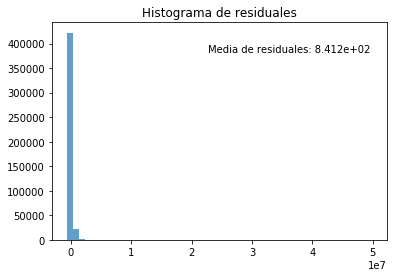

In [144]:
predictions = lr.predict(data)
f, ax = plt.subplots(1)
ax.hist(target - predictions, bins=50, alpha=0.7)
ax.set_title('Histograma de residuales')
ax.text(0.95, 0.90, 'Media de residuales: {:.3e}'.format(np.mean(target - predictions)),
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')

# Preproceso del set de test 

In [145]:
columnsToEvaluate = columns
columnsToEvaluate

['cancha de tenis',
 'club house',
 'cochera',
 'comedor',
 'futbol 5',
 'living',
 'pileta',
 'piscina',
 'place_with_parent_names',
 'sector de juegos infantiles',
 'seguridad las 24 hs']

In [272]:
def deleteColumnsTestData(df, columnsToEvaluate):
    columns = list(df.columns.values)
    for column in columns:
        if column in columnsToEvaluate:
            continue
        df.drop(column, axis = 1, inplace = True)
    return df

In [273]:
def preProcessTestData(df):
    df = filterUnnecesaryColumns(df, True)
    df['rooms'] = getRooms(df)
    df['surface_total_in_m2'] = getSurface(df)
    df['description'] = crear_diccionario_descripcion(df)
    df = addDescriptionColumns(df, 'description')
    df = changePlaceWithParentsNamesColumn(df)
    df = changePropertyTypeColumn(df)
    return df

In [274]:
def GetDataAsList(df):
    columns = list(df.columns.values)
    data = list(df.values)
    return data

In [326]:
predictDf = pd.read_csv("properati_dataset_testing_noprice.csv", low_memory = False)

In [327]:
predictDf = preProcessTestData(predictDf)

In [157]:
ids = predictDf['id']

In [158]:
predictDf = deleteColumnsTestData(predictDf, columnsToEvaluate)

In [159]:
data = GetDataAsList(predictDf)

In [160]:
print "data size: ", len(data)
print "df size: ", len(predictDf.index)
print "columns size: ", len(predictDf.columns.values)
#row should be 14166

data size:  14166
df size:  14166
columns size:  11


In [161]:
predictions = lr.predict(data)

In [162]:
final = pd.DataFrame()
final['id'] = ids
final['price_usd'] = predictions

In [163]:
final = final.reset_index()
final.drop('index', axis = 1, inplace = True)

In [165]:
final.to_csv("properati_dataset_sample_submision.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')